In [59]:
import os
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import numpy as np
from tqdm import tqdm
from sklearn.svm import SVC
from skimage.measure import regionprops
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score

# Read the dataset from the drive

In [60]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [61]:
class params:
  data_path = '/content/drive/MyDrive/Fruit classification'
  Apple_images = '/content/drive/MyDrive/Fruit classification/Apple'
  Banana_images = '/content/drive/MyDrive/Fruit classification/Banana'
  Pear_images = '/content/drive/MyDrive/Fruit classification/Pear'
  csv_files = '/content/drive/MyDrive/Fruit classification/csv_files'

In [62]:
all_images = os.listdir(params.Apple_images) + os.listdir(params.Banana_images) + os.listdir(params.Pear_images)
dataset = pd.DataFrame(
    {
        'images': [f"{params.Apple_images}/{x}" for x in os.listdir(params.Apple_images)] + [f"{params.Banana_images}/{x}" for x in os.listdir(params.Banana_images)] + [f"{params.Pear_images}/{x}" for x in os.listdir(params.Pear_images)],
        'label': [0]*len(os.listdir(params.Apple_images)) + [1]*len(os.listdir(params.Banana_images)) + [2]*len(os.listdir(params.Pear_images))
        }
    )

In [63]:
dataset.head(6)

,images,label
0,/content/drive/MyDrive/Fruit classification/Ap...,0
1,/content/drive/MyDrive/Fruit classification/Ap...,0
2,/content/drive/MyDrive/Fruit classification/Ap...,0
3,/content/drive/MyDrive/Fruit classification/Ap...,0
4,/content/drive/MyDrive/Fruit classification/Ap...,0
5,/content/drive/MyDrive/Fruit classification/Ap...,0


In [64]:
dataset['label'].value_counts()

label
0    201
1    200
2    200
Name: count, dtype: int64

In [65]:
X = dataset['images']
y = dataset['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42, stratify = y)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((480,), (121,), (480,), (121,))

# Feature Extraction Process

In [66]:
import cv2
import numpy as np
import pandas as pd
from skimage.measure import regionprops
from tqdm import tqdm

def extract_shape_features(image_paths):
    """
    Extract shape-related features from a list of images.

    Args:
        image_paths (list): List of paths to the images.

    Returns:
        pd.DataFrame: DataFrame containing size-related features for each image.
    """
    # Initialize lists to store features
    hue_list = []
    compactness_list = []
    eccentricity_list = []
    solidity_list = []
    sphericity_list = []
    homogeneity_list = []
    image_path_list = []  # List to store image paths

    # Iterate over image paths with tqdm progress bar
    for image_path in tqdm(image_paths, desc="Extracting shape Features"):
        # Load image using OpenCV
        image = cv2.imread(image_path)

        # Resize the image to 100x100
        resized_image = cv2.resize(image, (100, 100))

        # Convert the resized image to grayscale
        gray = cv2.cvtColor(resized_image, cv2.COLOR_BGR2GRAY)

        # Convert the resized image to HSV color space
        hsv = cv2.cvtColor(resized_image, cv2.COLOR_BGR2HSV)

        # Threshold the image to obtain a binary mask
        _, binary = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)

        # Find contours in the binary mask
        contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        # Get the largest contour (assumed to be the object of interest)
        if len(contours) > 0:
            largest_contour = max(contours, key=cv2.contourArea)
        else:
            # Return default values if no contour is found
            hue_list.append(0)
            compactness_list.append(0)
            eccentricity_list.append(0)
            solidity_list.append(0)
            sphericity_list.append(0)
            homogeneity_list.append(0)
            continue

        # Compute region properties of the binary mask
        props = regionprops(binary.astype(int))[0]

        # Extract size-related features
        compactness = (props.perimeter ** 2) / props.area
        eccentricity = props.eccentricity
        solidity = props.solidity

        # Calculate sphericity
        sphericity = (props.equivalent_diameter ** 2) / props.area

        # Calculate homogeneity
        homogeneity = cv2.HuMoments(cv2.moments(gray)).flatten()

        # Calculate average hue value
        hue = np.mean(hsv[:,:,0])

        # Append the extracted features to the lists
        image_path_list.append(image_path)  # Append image path
        hue_list.append(hue)
        compactness_list.append(compactness)
        eccentricity_list.append(eccentricity)
        solidity_list.append(solidity)
        sphericity_list.append(sphericity)
        homogeneity_list.append(np.mean(homogeneity))  # Take the mean of homogeneity values

    # Create a DataFrame from the lists of features
    features_df = pd.DataFrame({
        'image_paths': image_path_list,  # Add image paths as a new column
        'hue': hue_list,
        'compactness': compactness_list,
        'eccentricity': eccentricity_list,
        'solidity': solidity_list,
        'sphericity': sphericity_list,
        'homogeneity': homogeneity_list
    })
    return features_df

In [67]:
features_df = extract_shape_features(image_paths = X_train.values)

Extracting shape Features: 100%|██████████| 480/480 [00:07<00:00, 63.91it/s]


In [68]:
features_df["Fruit"] = y_train.values
features_df.drop(columns=['Size'], inplace=True, errors='ignore')
features_df.drop(columns=['sphericity'], inplace=True, errors='ignore')
features_df.head()

,image_paths,hue,compactness,eccentricity,solidity,homogeneity,Fruit
0,/content/drive/MyDrive/Fruit classification/Pe...,20.5416,37.883728,0.176934,0.927325,0.000152,2
1,/content/drive/MyDrive/Fruit classification/Ap...,54.0428,98.408613,0.378486,0.500100,0.000143,0
2,/content/drive/MyDrive/Fruit classification/Pe...,20.2401,25.132439,0.607799,0.912741,0.000162,2
3,/content/drive/MyDrive/Fruit classification/Pe...,20.6483,33.855992,0.162696,0.929715,0.000153,2
4,/content/drive/MyDrive/Fruit classification/Ap...,15.9063,19.277463,0.310930,0.981105,0.000135,0


In [69]:
features_df.to_csv(f"{params.csv_files}/Train.csv", index = False)

In [70]:
features_test = extract_shape_features(image_paths = X_test.values)

Extracting shape Features: 100%|██████████| 121/121 [00:01<00:00, 75.77it/s]


In [71]:
features_test["Fruit"] = y_test.values
features_test.drop(columns=['sphericity'], inplace=True, errors='ignore')
features_test.head()

,image_paths,hue,compactness,eccentricity,solidity,homogeneity,Fruit
0,/content/drive/MyDrive/Fruit classification/Pe...,19.9238,27.733034,0.470512,0.944186,0.000162,2
1,/content/drive/MyDrive/Fruit classification/Pe...,21.4660,40.983055,0.190227,0.934777,0.000155,2
2,/content/drive/MyDrive/Fruit classification/Ba...,47.6058,39.090447,0.894227,0.632456,0.000133,1
3,/content/drive/MyDrive/Fruit classification/Pe...,20.0186,27.705738,0.455865,0.939995,0.000163,2
4,/content/drive/MyDrive/Fruit classification/Pe...,20.6480,84.089643,0.258697,0.716841,0.000153,2


In [72]:
features_test.to_csv(f"{params.csv_files}/Test.csv", index = False)

# Exploratory data visualization and feature analysis

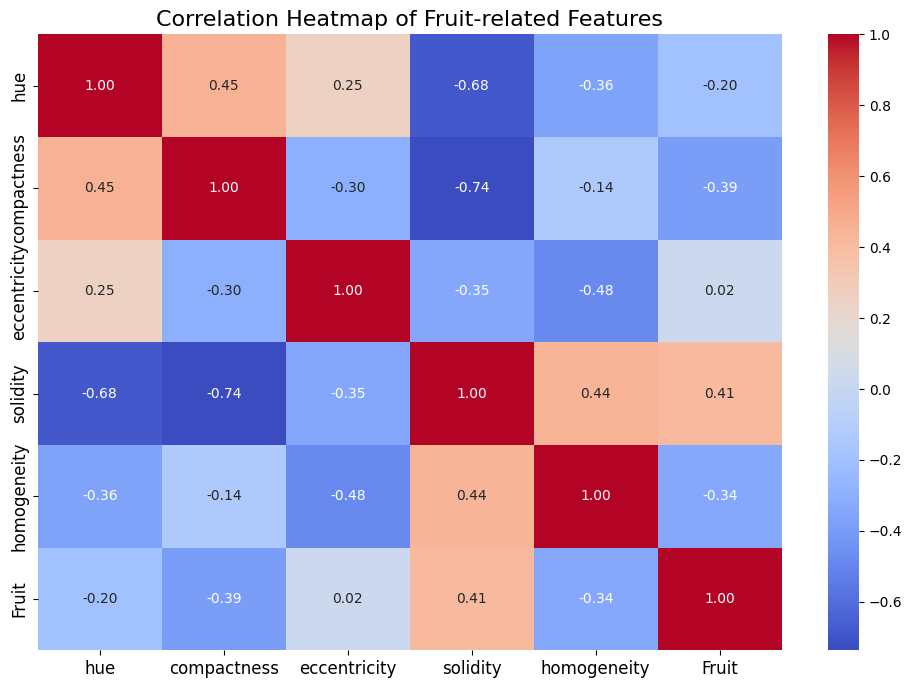

In [73]:
import seaborn as sns
import matplotlib.pyplot as plt

numeric_features_df = features_df.select_dtypes(include=['float64', 'int64'])

# Calculate correlation matrix
correlation_matrix = numeric_features_df.corr()

# Plot heatmap of correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", annot_kws={"size": 10})
plt.title('Correlation Heatmap of Fruit-related Features', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

In [74]:
train_df = pd.read_csv(f"{params.csv_files}/Train.csv")
test_df = pd.read_csv(f"{params.csv_files}/Test.csv")
train_df.shape, test_df.shape

((480, 7), (121, 7))

In [75]:
# Define the file paths for training and test data CSV files
train_csv_path = '/content/drive/MyDrive/Fruit classification/csv_files/Train.csv'
test_csv_path = '/content/drive/MyDrive/Fruit classification/csv_files/Test.csv'

# Function to count the number of occurrences of each category in a CSV file
def count_categories(csv_path):
    # Read the CSV file
    df = pd.read_csv(csv_path)
    # Count the occurrences of each category
    counts = df['Fruit'].value_counts().to_dict()
    return counts

# Count the number of occurrences of each category for training and test data
train_counts = count_categories(train_csv_path)
test_counts = count_categories(test_csv_path)

print("Training counts:", train_counts)
print("Test counts:", test_counts)

Training counts: {2: 160, 0: 160, 1: 160}
Test counts: {0: 41, 2: 40, 1: 40}


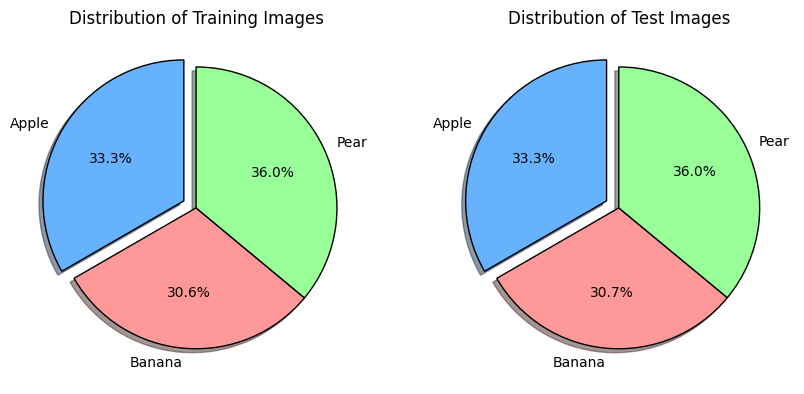

In [76]:
# Sample data
labels = ['Apple', 'Banana', 'Pear']
counts_train = [99, 91, 107]
counts_test = [25, 23, 27]

# Calculate percentages
total_count_train = sum(counts_train)
percentages_tr = [(count / total_count_train) * 100 for count in counts_train]

total_count_test = sum(counts_test)
percentages_test = [(count / total_count_test) * 100 for count in counts_test]

# Define pleasing colors
colors = ['#66b2ff', '#ff9999', '#99ff99']

# Plotting the 2D pie chart with shadow
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

# Define the amount of explosion (0.1 means 10% of the radius)
explode = (0.1, 0, 0)
ax[0].pie(percentages_tr, labels=labels, autopct='%1.1f%%', startangle=90, colors=colors,
          wedgeprops={'edgecolor': 'black'}, shadow=True, explode=explode)

# Add a title
ax[0].set_title('Distribution of Training Images')

ax[1].pie(percentages_test, labels=labels, autopct='%1.1f%%', startangle=90, colors=colors,
          wedgeprops={'edgecolor': 'black'}, shadow=True, explode=explode)

# Add a title
ax[1].set_title('Distribution of Test Images')

# Display the 2D pie chart with shadow
plt.show()


<ipython-input-77-f1f2bfb2bbec>:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(train_df["hue"], color = "green")


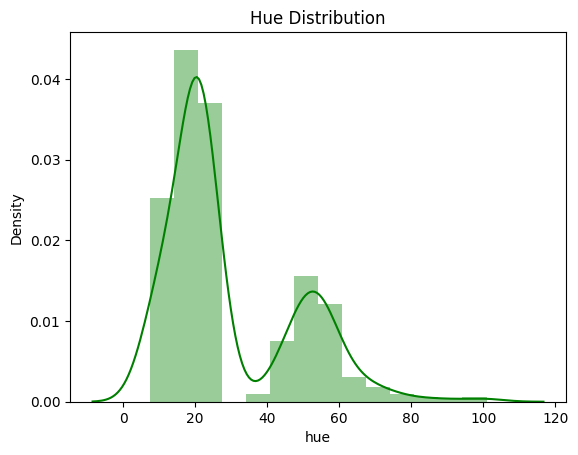

In [77]:
sns.distplot(train_df["hue"], color = "green")
plt.title("Hue Distribution")
plt.show()

<ipython-input-78-da4be2500960>:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(train_df["compactness"], color = "green")


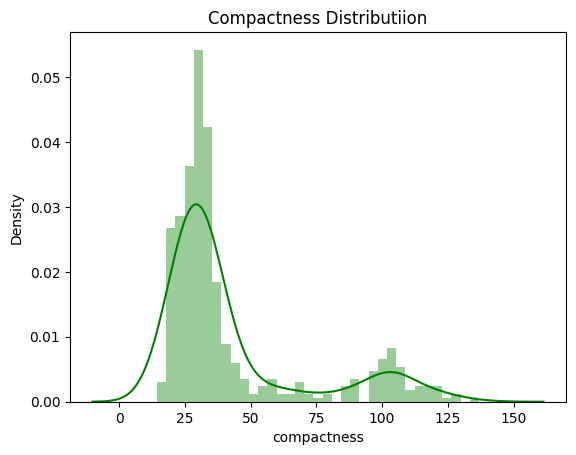

In [78]:
sns.distplot(train_df["compactness"], color = "green")
plt.title("Compactness Distributiion")
plt.show()

<ipython-input-79-79c0e9fdc8d6>:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(train_df["eccentricity"], color = "green")


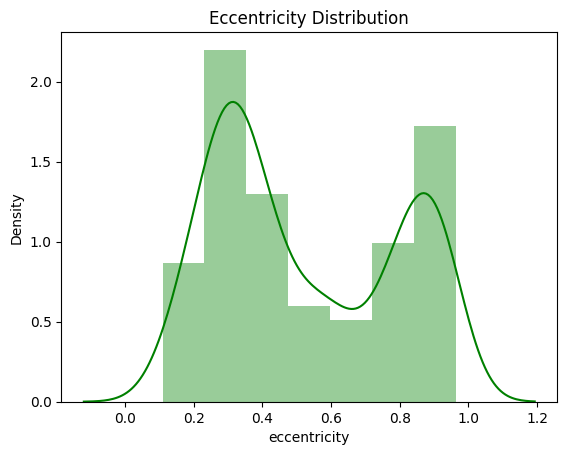

In [79]:
sns.distplot(train_df["eccentricity"], color = "green")
plt.title("Eccentricity Distribution")
plt.show()

<ipython-input-80-9eaecba700a2>:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(train_df["solidity"], color = "green")


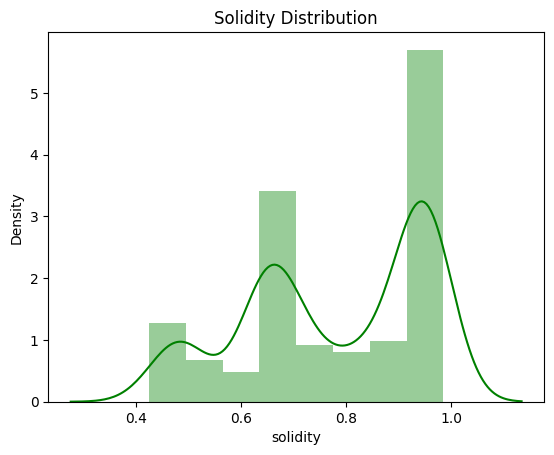

In [80]:
sns.distplot(train_df["solidity"], color = "green")
plt.title("Solidity Distribution")
plt.show()

<ipython-input-81-ae4278155290>:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(train_df["homogeneity"], color = "green")


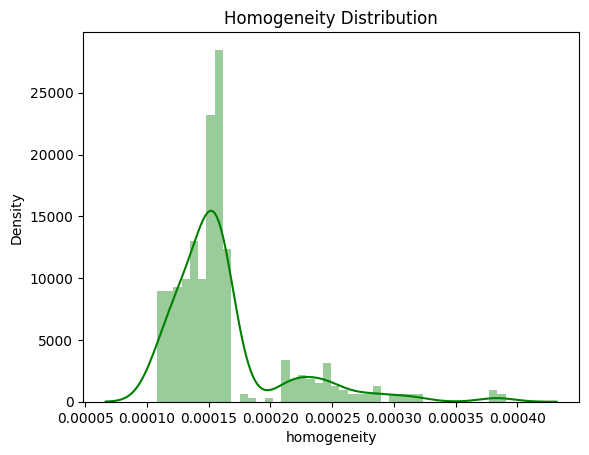

In [81]:
sns.distplot(train_df["homogeneity"], color = "green")
plt.title("Homogeneity Distribution")
plt.show()

In [82]:
train_df.columns

Index(['image_paths', 'hue', 'compactness', 'eccentricity', 'solidity',
       'homogeneity', 'Fruit'],
      dtype='object')

# Create subsets of features

In [83]:
features = ['compactness', 'eccentricity', 'solidity', 'hue', 'homogeneity']
features_reduced = ['compactness', 'eccentricity', 'solidity', 'hue']
features_reduced2 = ['eccentricity', 'solidity', 'hue', 'homogeneity']
features_reduced3 = ['eccentricity']
features_reduced4 = ['solidity']
features_reduced5 = ['homogeneity']

target = ['Fruit']

# Train and Iterate an SVM classifier on all the features and get the metric scores

In [143]:
# Define lists to store evaluation metrics
accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []

# Define feature sets
feature_sets = {
    'all_features': features,
    'reduced_features': features_reduced,
    'reduced_features2': features_reduced2,
    'reduced_features3': features_reduced3,
    'reduced_features4': features_reduced4,
    'reduced_features5': features_reduced5,
}

# Define parameter grid
param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf', 'poly'],
}

# Create a scaler instance
scaler = StandardScaler()

# Train and evaluate SVM classifiers for each feature set using GridSearchCV
for name, feature_set in feature_sets.items():
    # Prepare training and test data for the current feature set
    X_train = train_df[feature_set]
    y_train = np.ravel(train_df[target])
    X_test = test_df[feature_set]
    y_test = np.ravel(test_df[target])

    # Scale the features
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Create SVM classifier
    svm_classifier = SVC()

    # Perform GridSearchCV
    grid_search = GridSearchCV(svm_classifier, param_grid, scoring='f1_weighted', cv=5)
    grid_search.fit(X_train_scaled, y_train)

    # Get the best model
    best_svm = grid_search.best_estimator_

    # Print the best parameters for the current feature set
    print(f'Best parameters for {name}: {grid_search.best_params_}')

    # Predict labels on the test set using the best model
    y_pred = best_svm.predict(X_test_scaled)

    # Calculate evaluation metrics for the current feature set
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')

    # Print evaluation metrics for the current feature set
    print(f'Evaluation metrics for {name}:')
    print(f'Accuracy: {accuracy}, Precision: {precision}, Recall: {recall}, F1 Score: {f1}')

    # Append evaluation metrics to the respective lists
    accuracy_scores.append(accuracy)
    precision_scores.append(precision)
    recall_scores.append(recall)
    f1_scores.append(f1)


Best parameters for all_features: {'C': 10, 'kernel': 'rbf'}
Evaluation metrics for all_features:
Accuracy: 1.0, Precision: 1.0, Recall: 1.0, F1 Score: 1.0
Best parameters for reduced_features: {'C': 10, 'kernel': 'rbf'}
Evaluation metrics for reduced_features:
Accuracy: 0.9834710743801653, Precision: 0.9838742189074784, Recall: 0.9834710743801653, F1 Score: 0.983366493214978
Best parameters for reduced_features2: {'C': 10, 'kernel': 'rbf'}
Evaluation metrics for reduced_features2:
Accuracy: 0.9917355371900827, Precision: 0.9919371094537393, Recall: 0.9917355371900827, F1 Score: 0.9917355371900827
Best parameters for reduced_features3: {'C': 10, 'kernel': 'rbf'}
Evaluation metrics for reduced_features3:
Accuracy: 0.7933884297520661, Precision: 0.7939387581189544, Recall: 0.7933884297520661, F1 Score: 0.7913354600919907
Best parameters for reduced_features4: {'C': 10, 'kernel': 'rbf'}
Evaluation metrics for reduced_features4:
Accuracy: 0.7851239669421488, Precision: 0.789632505561432, R

# Visualize the evaluation metrics

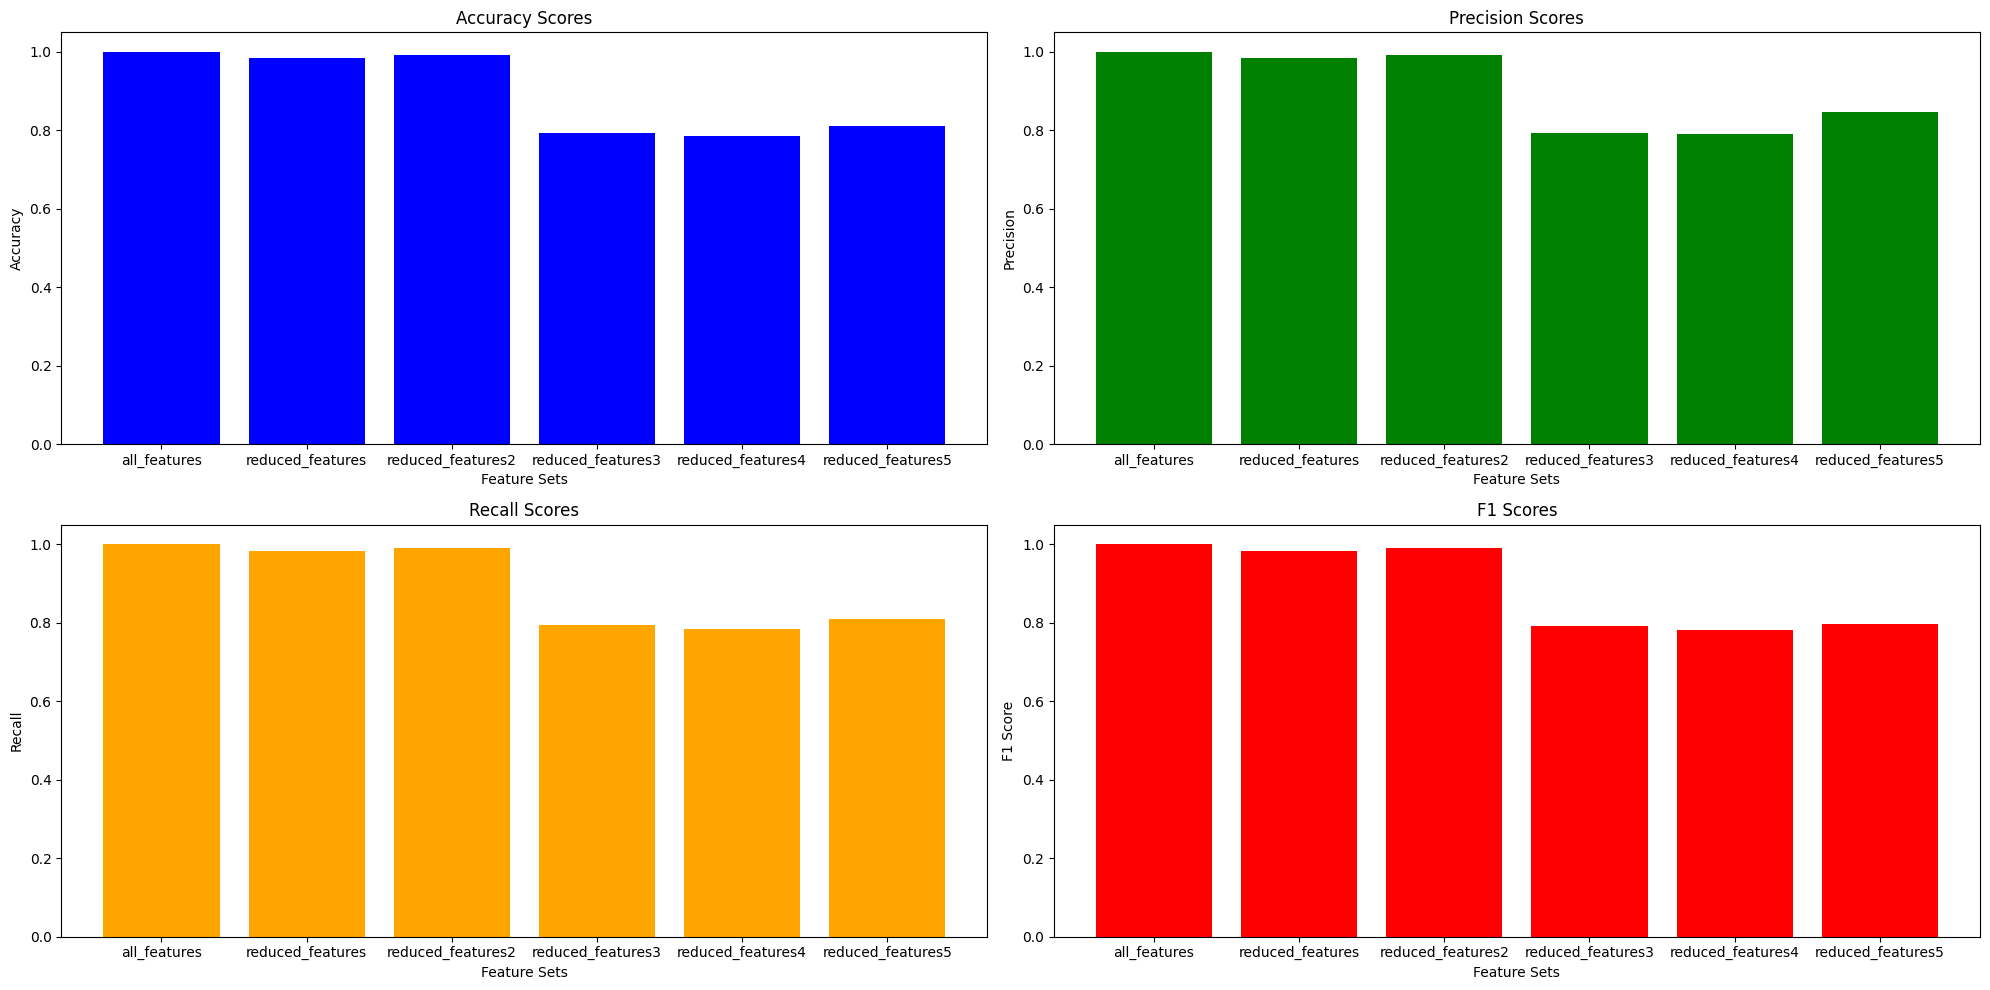

In [144]:
# Plot histograms for evaluation metrics
plt.figure(figsize=(20, 10))

plt.subplot(2, 2, 1)
plt.bar(list(feature_sets.keys()), accuracy_scores, color='blue')
plt.title('Accuracy Scores')
plt.xlabel('Feature Sets')
plt.ylabel('Accuracy')

plt.subplot(2, 2, 2)
plt.bar(list(feature_sets.keys()), precision_scores, color='green')
plt.title('Precision Scores')
plt.xlabel('Feature Sets')
plt.ylabel('Precision')

plt.subplot(2, 2, 3)
plt.bar(list(feature_sets.keys()), recall_scores, color='orange')
plt.title('Recall Scores')
plt.xlabel('Feature Sets')
plt.ylabel('Recall')

plt.subplot(2, 2, 4)
plt.bar(list(feature_sets.keys()), f1_scores, color='red')
plt.title('F1 Scores')
plt.xlabel('Feature Sets')
plt.ylabel('F1 Score')

plt.tight_layout()
plt.show()

# Evaluation on seperare test set

In [148]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
import os
import pandas as pd
import matplotlib.pyplot as plt
import cv2

# Function to display image with prediction
def display_image_with_prediction(image_path, prediction):
    # Read the image
    image = cv2.imread(image_path)
    # Convert BGR to RGB
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    # Display the image
    plt.imshow(image)
    # Set title with prediction
    plt.title(f'Prediction: {prediction}')
    plt.axis('off')
    plt.show()

# Define the directory containing test images
test_data_dir = '/content/drive/My Drive/Fruits Tests'

# List all image files in the test directory
test_image_files = [os.path.join(test_data_dir, filename) for filename in os.listdir(test_data_dir) if filename.endswith(('.jpg', '.png'))]

# Extract shape features from the test images
features_new_test = extract_shape_features(test_image_files)
features_new_test.drop(columns=['sphericity'], inplace=True, errors='ignore')
features_new_test.to_csv(f"{params.csv_files}/New Test.csv", index=False)
new_test_df = pd.read_csv(f"{params.csv_files}/New Test.csv")

Extracting shape Features: 100%|██████████| 29/29 [00:00<00:00, 66.35it/s]


In [160]:
# Initialize lists to store actual and predicted labels
actual_labels = []
predicted_labels_all = []

# Iterate over test images
for image_path in test_image_files:
    # Extract actual label from image file name
    actual_label = os.path.basename(image_path).split("(")[0].split(".")[0].strip()  # Strip leading/trailing whitespace
    # Append actual label to list
    actual_labels.append(actual_label)

# Map label names to numeric classes
label_mapping = {'apple': 0, 'banana': 1, 'pear': 2}

# Define inverse label mapping
inverse_label_mapping = {v: k for k, v in label_mapping.items()}

# Iterate over feature sets
for name, feature_set in feature_sets.items():
    # Prepare test data for the current feature set
    X_test = new_test_df[feature_set]

    # Scale the features for test data
    X_test_scaled = scaler.transform(X_test)

    # Predict labels on the test set using the best model
    y_pred = best_svm.predict(X_test_scaled)

    # Map predicted class to label name
    predicted_labels = [inverse_label_mapping[prediction] for prediction in y_pred]

    # Append predicted labels for the current feature set
    predicted_labels_all.append(predicted_labels)

# Flatten the list of predicted labels for all feature sets
predicted_labels_flat = [label for sublist in predicted_labels_all for label in sublist]

# Convert all actual and predicted labels to lowercase and strip leading/trailing whitespace
actual_labels_lower = [label.lower().strip() for label in actual_labels]
predicted_labels_flat_lower = [label.lower().strip() for label in predicted_labels_flat]

# Calculate evaluation metrics based on all predictions
accuracy = accuracy_score(actual_labels_lower, predicted_labels_flat_lower)
precision = precision_score(actual_labels_lower, predicted_labels_flat_lower, average='weighted')
recall = recall_score(actual_labels_lower, predicted_labels_flat_lower, average='weighted')
f1 = f1_score(actual_labels_lower, predicted_labels_flat_lower, average='weighted')

# Print evaluation metrics
print("Evaluation metrics for all feature sets:")
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Evaluation metrics for all feature sets:
Accuracy: 0.5862068965517241
Precision: 0.5545450717864512
Recall: 0.5862068965517241
F1 Score: 0.5585736543492958


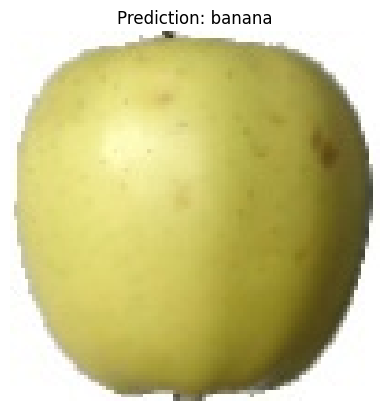

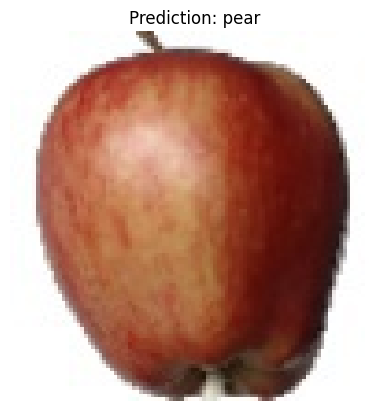

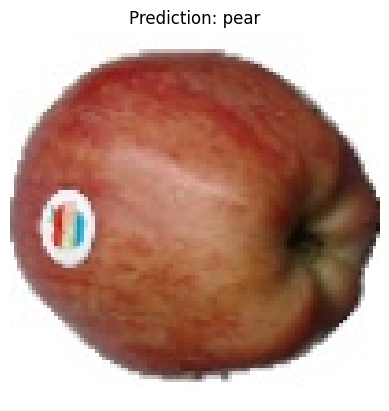

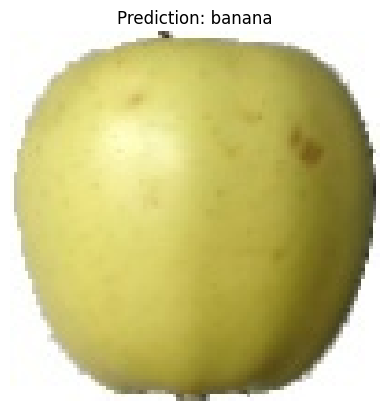

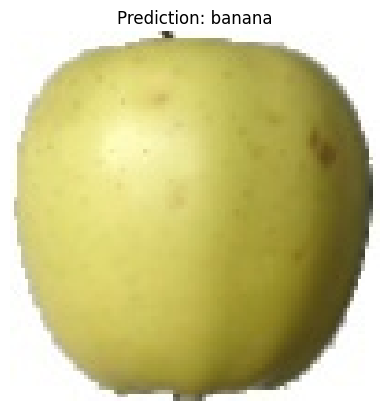

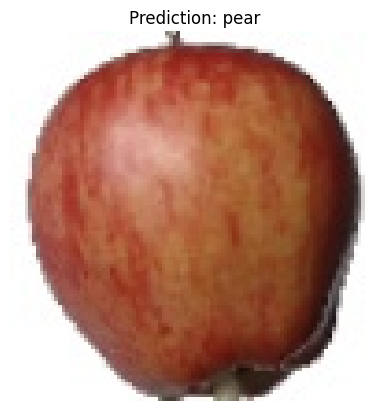

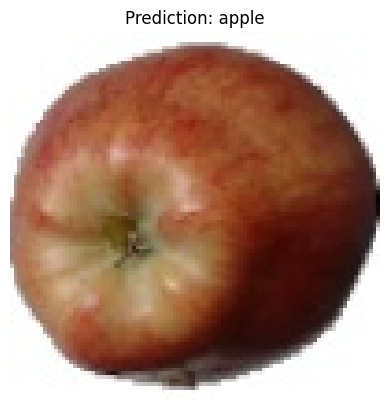

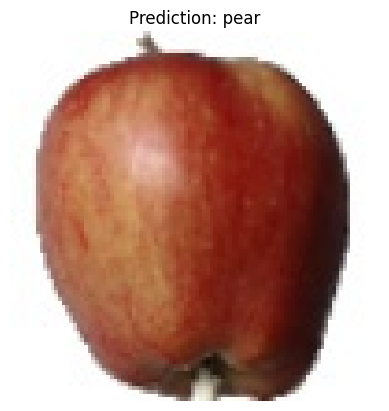

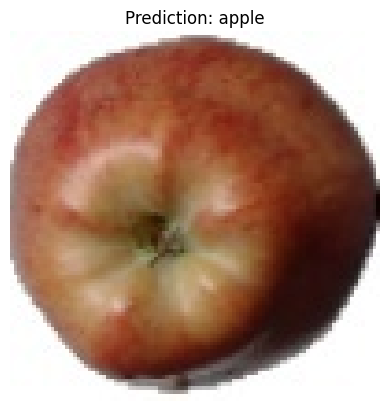

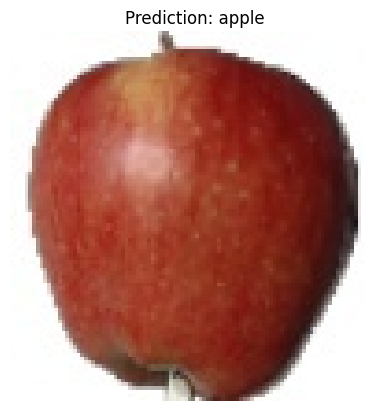

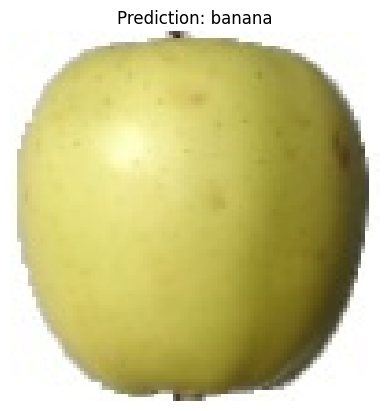

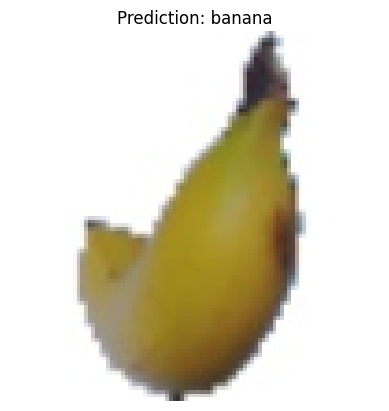

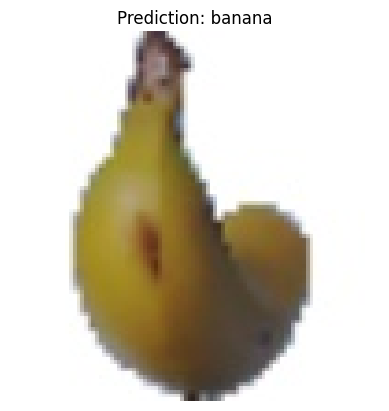

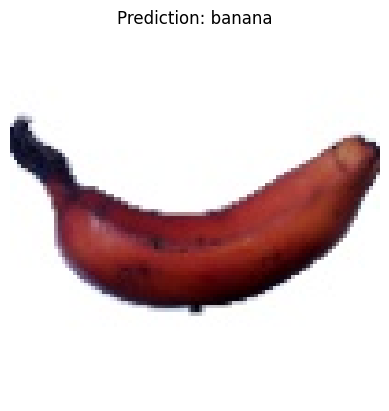

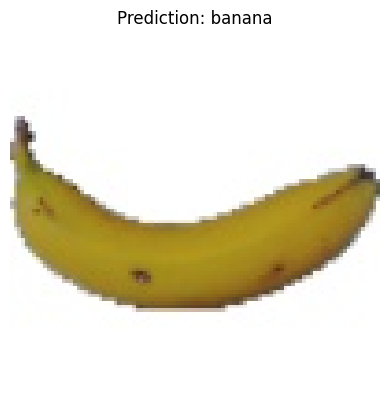

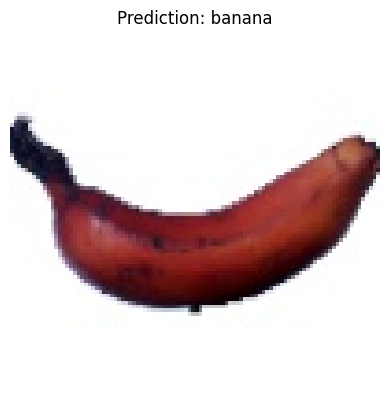

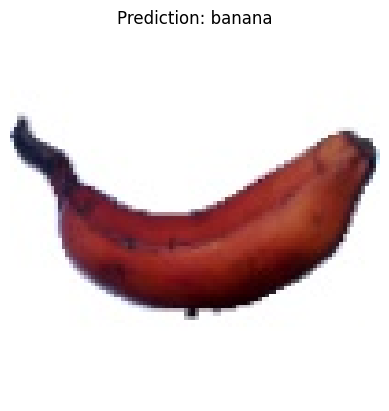

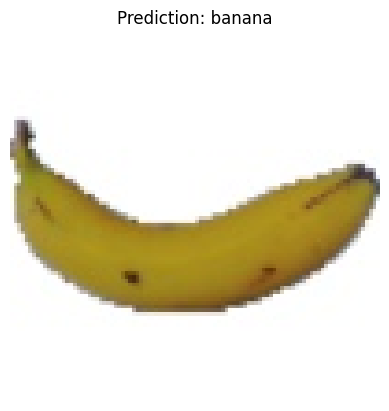

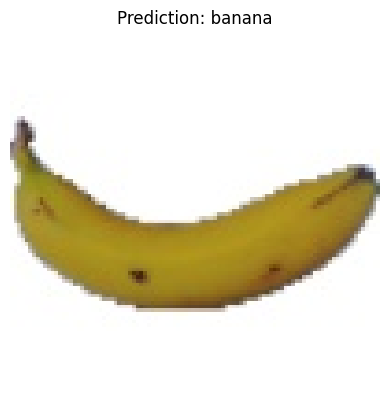

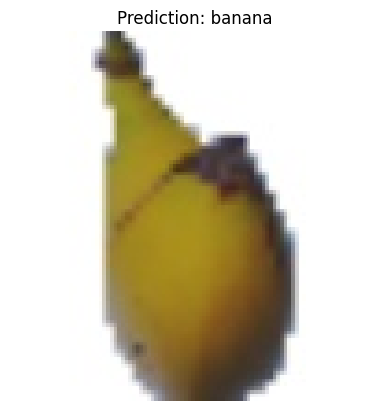

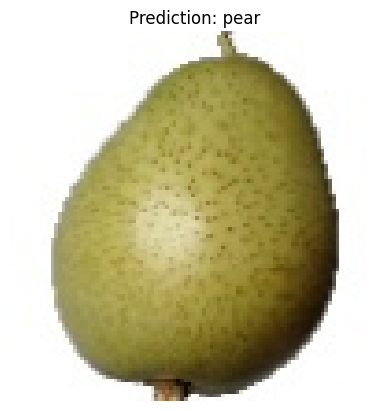

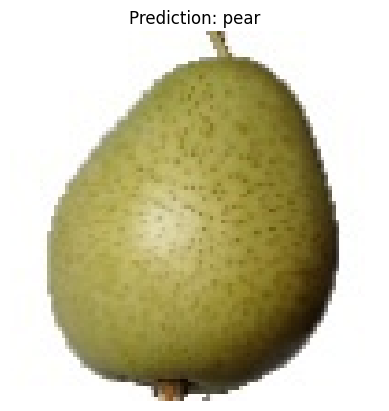

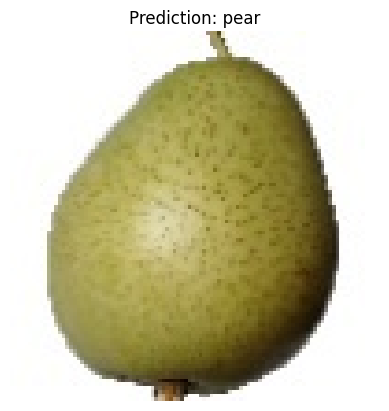

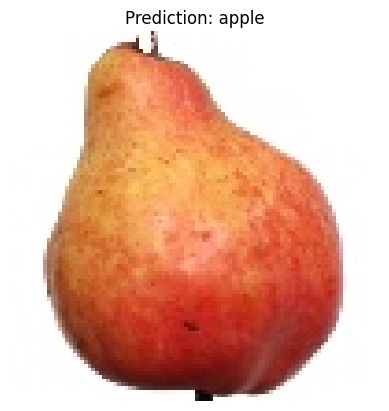

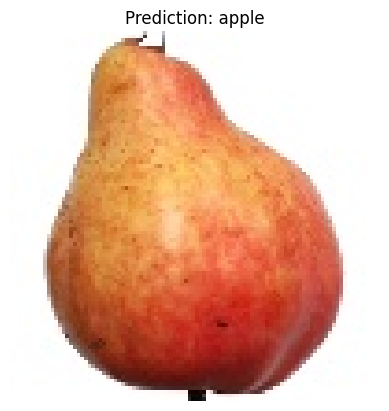

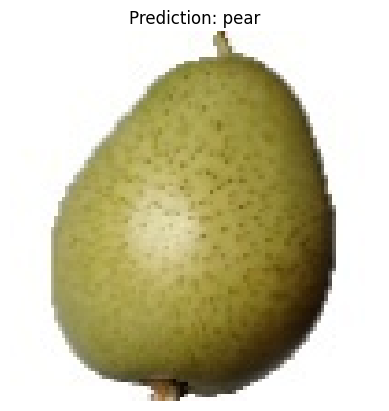

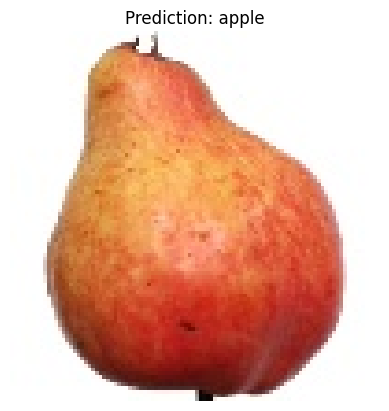

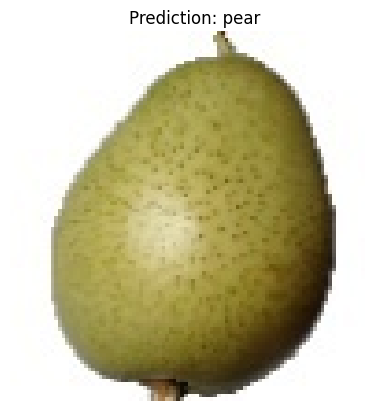

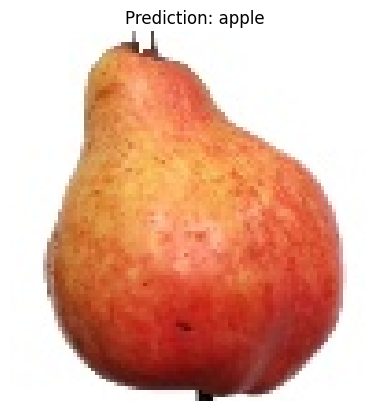

In [146]:
# Function to display image with prediction
def display_image_with_prediction(image_path, prediction):
    # Read the image
    image = cv2.imread(image_path)
    # Convert BGR to RGB
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    # Display the image
    plt.imshow(image)
    # Set title with prediction
    plt.title(f'Prediction: {prediction}')
    plt.axis('off')
    plt.show()
# Iterate over test images and their predicted labels
for image_path, predicted_label in zip(test_image_files, predicted_labels_flat):
    # Display image with predicted label
    display_image_with_prediction(image_path, predicted_label)

In [135]:
from collections import Counter

# Preprocess actual_labels to remove leading and trailing spaces
actual_labels_processed = [label.strip() for label in actual_labels]

# Count occurrences of each unique label in actual_labels
actual_label_counts = Counter(actual_labels_processed)

# Count occurrences of each unique label in predicted_labels
predicted_label_counts = Counter(predicted_labels)

# Print the counts
print("Actual Label Counts:", actual_label_counts)
print("Predicted Label Counts:", predicted_label_counts)

Actual Label Counts: Counter({'Apple': 11, 'Banana': 10, 'Pear': 8})
Predicted Label Counts: Counter({'banana': 13, 'pear': 9, 'apple': 7})


In [151]:
# Iterate over test images and print actual and predicted labels
for image_path, actual_label, predicted_label in zip(test_image_files, actual_labels_lower, predicted_labels_flat_lower):
    print("Image Path:", image_path)
    print("Actual Label:", actual_label)
    print("Predicted Label:", predicted_label)
    print()

Image Path: /content/drive/My Drive/Fruits Tests/Apple (8).jpg
Actual Label: apple 
Predicted Label: banana

Image Path: /content/drive/My Drive/Fruits Tests/Apple (1).jpg
Actual Label: apple 
Predicted Label: pear

Image Path: /content/drive/My Drive/Fruits Tests/Apple (5).jpg
Actual Label: apple 
Predicted Label: pear

Image Path: /content/drive/My Drive/Fruits Tests/Apple (3).jpg
Actual Label: apple 
Predicted Label: banana

Image Path: /content/drive/My Drive/Fruits Tests/Apple (9).jpg
Actual Label: apple 
Predicted Label: banana

Image Path: /content/drive/My Drive/Fruits Tests/Apple.jpg
Actual Label: apple
Predicted Label: pear

Image Path: /content/drive/My Drive/Fruits Tests/Apple (7).jpg
Actual Label: apple 
Predicted Label: apple

Image Path: /content/drive/My Drive/Fruits Tests/Apple (2).jpg
Actual Label: apple 
Predicted Label: pear

Image Path: /content/drive/My Drive/Fruits Tests/Apple (6).jpg
Actual Label: apple 
Predicted Label: apple

Image Path: /content/drive/My Driv

In [159]:
# Print actual and predicted labels in pairs
for actual_label, predicted_label in zip(actual_labels_lower, predicted_labels_flat_lower):
    print(f"({actual_label.strip()}, {predicted_label.strip()})", end=" ")

(apple, banana) (apple, pear) (apple, pear) (apple, banana) (apple, banana) (apple, pear) (apple, apple) (apple, pear) (apple, apple) (apple, apple) (apple, banana) (banana, banana) (banana, banana) (banana, banana) (banana, banana) (banana, banana) (banana, banana) (banana, banana) (banana, banana) (banana, banana) (pear, pear) (pear, pear) (pear, pear) (pear, apple) (pear, apple) (pear, pear) (banana, apple) (pear, pear) (pear, apple) 